## Explainable ML – Supreme Court Database (SCDB) 

In this notebook, I use the Supreme Court Database (SCDB, 2025 Release 01, Case-Centered, Issue/Legal Provision format) to explore predictive modeling of Supreme Court case outcomes.

Dataset Source: SCDB – http://scdb.wustl.edu/data.php 

Unit of Analysis: Case/issue/legal provision (13,930 rows).

### Target Variable:

partyWinning → binary outcome (1 = petitioner won, 0 = respondent won).

### Engineered Features:

vote_margin → difference between majority and minority votes.

lawType_simplified → collapsed into {constitutional, statutory, other}.

petitioner_group / respondent_group → broad groups (Federal Gov, State Gov, Local Gov, Business, Individual, Other).

term → used as year .

### Other Predictors:

issueArea → policy domain (14 categories).

lcDispositionDirection → lower court ruling direction.

lcDisagreement → whether the lower court was divided.

**The goal is to:**

Build a predictive model (RandomForestClassifier) for partyWinning.

Perform exploratory data analysis to understand correlations between features.

Generate and interpret PDP (Partial Dependence Plots), ICE (Individual Conditional Expectation), and ALE (Accumulated Local Effects) plots.

Compare insights from PDP vs ALE, noting the impact of correlated features.

In [19]:
import pandas as pd

df=pd.read_csv("SCDB_2025_01_caseCentered_LegalProvision.csv")
print(df.shape)
# print(df.columns)
# df.head()

# Party Winning
# print(df["partyWinning"].value_counts(dropna=False))

# # Decision Direction
# print(df["decisionDirection"].value_counts(dropna=False))

# # Case Disposition
# print(df["caseDisposition"].value_counts(dropna=False))

df = df.dropna(subset=["partyWinning"])



(13930, 53)


Initial data has been loaded and checked for missing values. Cleaned up the missing data .

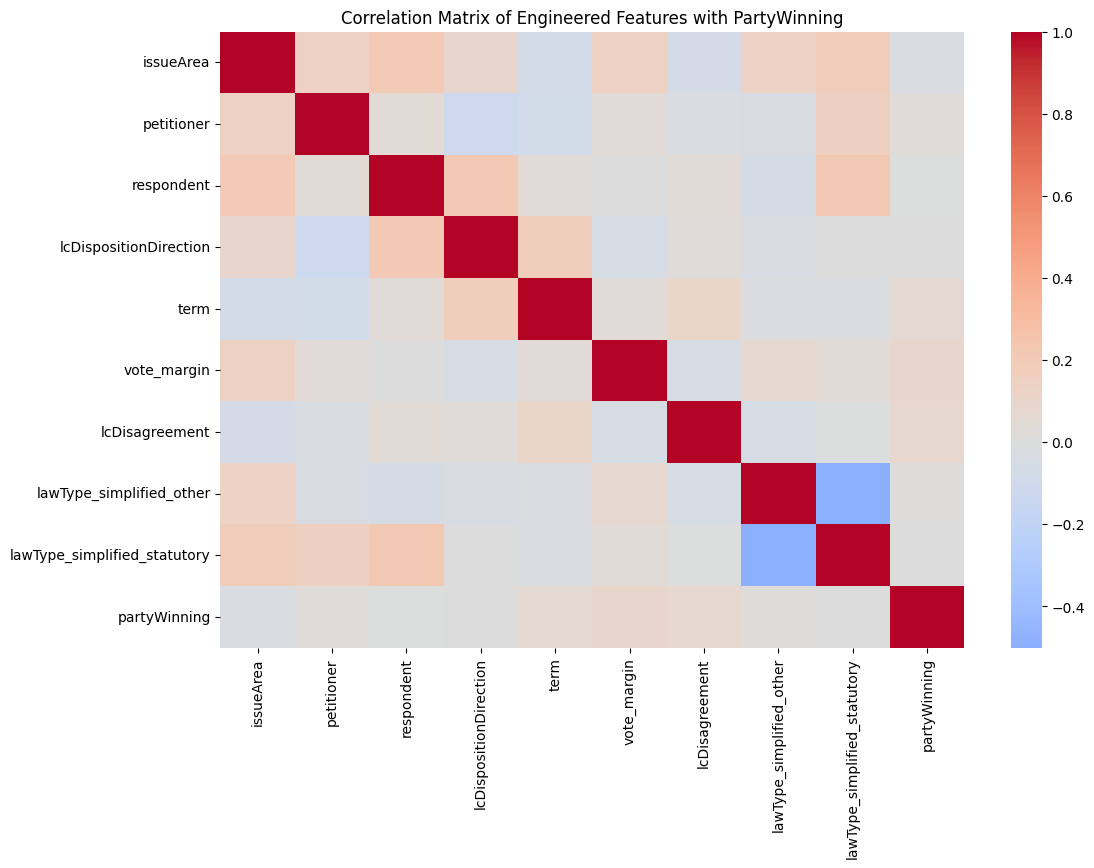

partyWinning                    1.000000
vote_margin                     0.096659
lcDisagreement                  0.076674
term                            0.060762
petitioner                      0.018923
lawType_simplified_other        0.011900
lcDispositionDirection          0.006207
lawType_simplified_statutory    0.004417
respondent                     -0.001915
issueArea                      -0.028075
Name: partyWinning, dtype: float64


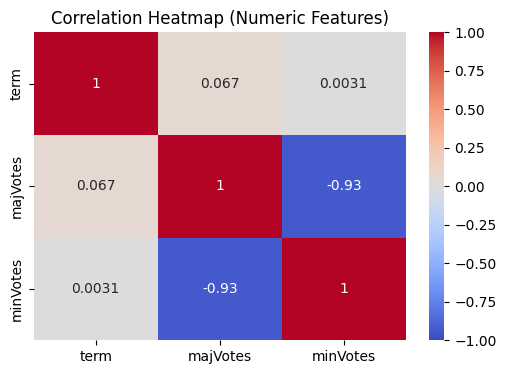

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1. Feature engineering ---
df = df[df["partyWinning"].isin([0.0, 1.0])]   # keep binary target only
# Create vote margin feature
df["vote_margin"] = df["majVotes"] - df["minVotes"]

# Collapse lawType into broad categories (constitutional/statutory/other)
def collapse_lawtype(x):
    if x in [1.0, 2.0]:   # check SCDB codebook
        return "constitutional"
    elif x in [3.0, 4.0]:
        return "statutory"
    else:
        return "other"

df["lawType_simplified"] = df["lawType"].apply(collapse_lawtype)

# Collapse petitioner/respondent codes into broad categories
def collapse_party(code):
    if pd.isna(code):
        return "Unknown"
    
    # Federal Government
    if code in [1.0, 2.0, 3.0, 4.0, 6.0]:  # U.S., federal agency, federal officials
        return "Federal Gov"
    
    # State Government
    elif 100.0 <= code < 200.0:  # state-related codes
        return "State Gov"
    
    # Local Government
    elif 200.0 <= code < 300.0:  # city, county, local officials
        return "Local Gov"
    
    # Business
    elif 300.0 <= code < 400.0:  # corporations, unions
        return "Business"
    
    # Individual
    elif 400.0 <= code < 500.0:  # individuals, private litigants
        return "Individual"
    
    # Other/Unknown
    else:
        return "Other"

# Apply to petitioner and respondent columns
df["petitioner_group"] = df["petitioner"].apply(collapse_party)
df["respondent_group"] = df["respondent"].apply(collapse_party)

# print(df[["petitioner", "petitioner_group", "respondent", "respondent_group"]].head(10))

# Select categorical columns
cat_cols = ["issueArea", "petitioner", "respondent", 
            "lcDispositionDirection", "term", "lawType_simplified"]


# --- Step 2. Select candidate features ---
features = [
    "issueArea",
    "petitioner",   
    "respondent",              # broad category
    "lcDispositionDirection", # lower court ideological direction
    "lcDisagreement",         # was there disagreement below
    "term",                 # decade of decision
    "vote_margin",             # margin of victory
    "lawType_simplified",   # simplified law type
]

X = df[features]
y = df["partyWinning"]
# print(X.info())
# print(X.head())

# --- Step 3. Encode categoricals ---
# Apply one-hot encoding
X_enc = pd.get_dummies(df[cat_cols + ["vote_margin", "lcDisagreement"]], drop_first=True)

# print(X_enc.head())

# Combine features + target
corr_df = pd.concat([X_enc, y], axis=1)

# --- Step 4. Correlation matrix ---
corr = corr_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar=True
)
plt.title("Correlation Matrix of Engineered Features with PartyWinning")
plt.show()

# --- Step 5. Focus only on correlations with target ---
print(corr["partyWinning"].sort_values(ascending=False))

# Only numeric features for correlation heatmap
num_cols = ["term", "majVotes", "minVotes"]
corr = df[num_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


### Picking a Target Variable and Features

binary or numeric outcome to the model.

CHOOSEN: partyWinning → 1 = petitioner won, 0 = respondent won


Choosing interpretable predictors.

CHOOSEN : issueArea (policy domain) ,petitioner , respondent , lcDispositionDirection (direction of lower court) , term

# Train a Model

Use a RandomForestClassifier (robust, handles categorical encodings).

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay


X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))


Train accuracy: 0.9926278881596692
Test accuracy: 0.777418194893923


In [21]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, balanced_accuracy_score, matthews_corrcoef,
    cohen_kappa_score, log_loss, brier_score_loss
)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("MCC:", matthews_corrcoef(y_test, y_pred))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_proba))
print("Brier Score:", brier_score_loss(y_test, y_proba))

Accuracy: 0.777418194893923
Balanced Accuracy: 0.7424191197422353
Precision: 0.7807241203467619
Recall: 0.8901162790697674
F1-score: 0.8318391741374627
ROC AUC: 0.8350311246520395
MCC: 0.5165032492562585
Cohen's Kappa: 0.5068952607274491
Log Loss: 0.4768932934753094
Brier Score: 0.15578666127939597


Checking the performance metrics of the model. Moderately good results.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


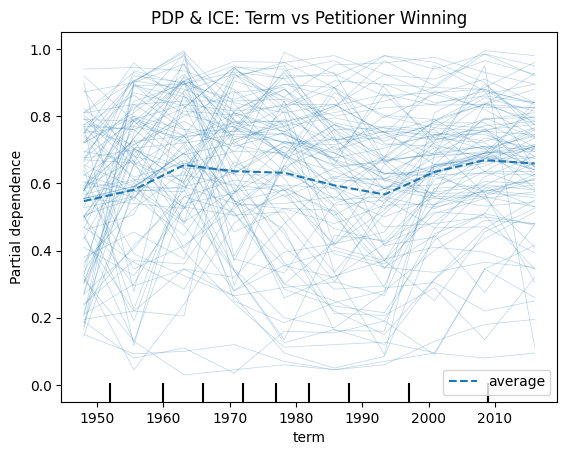

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


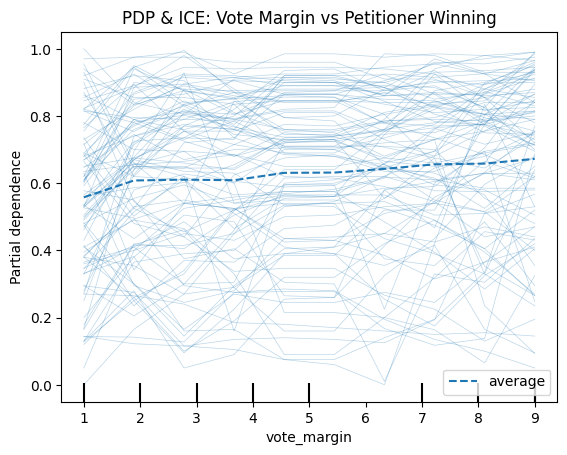

In [16]:
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    ["term"],
    kind="both",           # PDP + ICE
    subsample=100,         # sample 100 ICE lines
    random_state=42,
    grid_resolution=10
)
plt.title("PDP & ICE: Term vs Petitioner Winning")
plt.show()

# Vote margin
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    ["vote_margin"],
    kind="both",
    subsample=100,
    random_state=42,
    grid_resolution=10
)
plt.title("PDP & ICE: Vote Margin vs Petitioner Winning")
plt.show()


## PDP & ICE: Term vs Petitioner Winning

What the plot shows:

X-axis = Supreme Court term (year of decision).

Y-axis = predicted probability of petitioner win.

Thin blue lines = ICE curves (individual case effects).

Dashed blue line = PDP (average effect across all cases).

Inference:

The average PDP line suggests that petitioner win probability was around 0.55 in the 1950s, rose slightly to ~0.65 by the 1960s–1970s, dipped in the 1980s–1990s, and climbed again in the 2000s onward.

The spaghetti-like ICE curves highlight variability: some cases behave very differently from the overall trend.

The key takeaway is that on average, there is a long-term cyclical pattern in petitioner success, but outcomes vary significantly across individual disputes.

## PDP & ICE: Vote Margin vs Petitioner Winning

What the plot shows:

X-axis = vote margin (difference between majority and minority votes, 1–9).

Y-axis = predicted probability of petitioner win.

Thin blue lines = ICE (individual cases).

Dashed line = PDP (average).

Inference:

The average PDP line shows a slight upward trend: as vote margins increase, petitioner win probability edges higher.

At close margins (1–2 votes), petitioner win probability is lower on average compared to wider margins (7–9 votes).

ICE variation shows that not all close cases are unfavorable, but the general pattern is that petitioners do better in lopsided decisions than in razor-thin majorities.

PyALE._ALE_generic:INFO: Continuous feature detected.


,eff,size,lowerCI_95%,upperCI_95%
term,,,,
1946,0.017844,0.0,NaN,NaN
1948,0.063219,573.0,0.041300,0.085139
1952,0.016791,560.0,-0.010128,0.043709
1957,0.132447,709.0,0.099134,0.165759
1960,0.126274,486.0,0.098534,0.154014
1963,0.161988,560.0,0.138363,0.185613
1966,0.124064,501.0,0.101080,0.147047
1969,0.058777,628.0,0.033291,0.084263
1972,0.026674,623.0,0.003631,0.049718


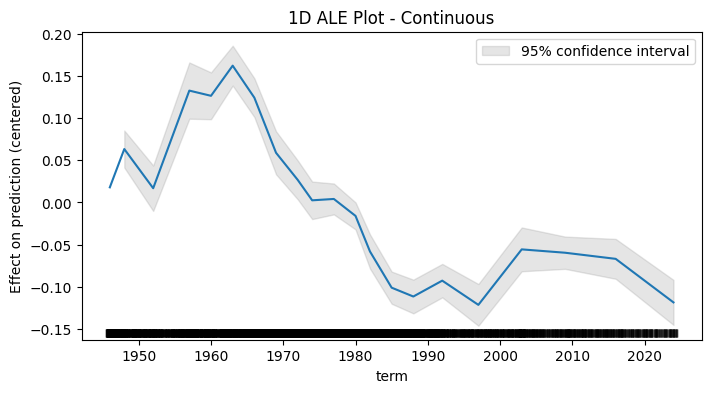

In [23]:
from PyALE import ale

ale(X=X_train, model=model, feature=["term"])



### Interpretation

In the 1950s–1960s, petitioner win probability effect was positive (above 0).

From the 1970s to the 1990s, the effect steadily declined, dipping negative around 1990.

From the 2000s onward, the effect remains mostly negative (petitioners less likely to win compared to baseline).

The wiggles reflect real differences between Court eras.

PyALE._ALE_generic:INFO: Discrete feature detected.


,eff,size,lowerCI_95%,upperCI_95%
vote_margin,,,,
0,-0.529346,87,NaN,NaN
1,-0.088199,1935,-0.109989,-0.066409
2,0.015057,399,-0.001541,0.031655
3,0.015537,1685,0.007386,0.023688
4,0.015537,415,0.007182,0.023892
5,0.017868,1301,0.005987,0.029749
6,0.023190,390,0.014748,0.031633
7,0.029259,1093,0.019631,0.038887
8,0.032865,848,0.022811,0.042920


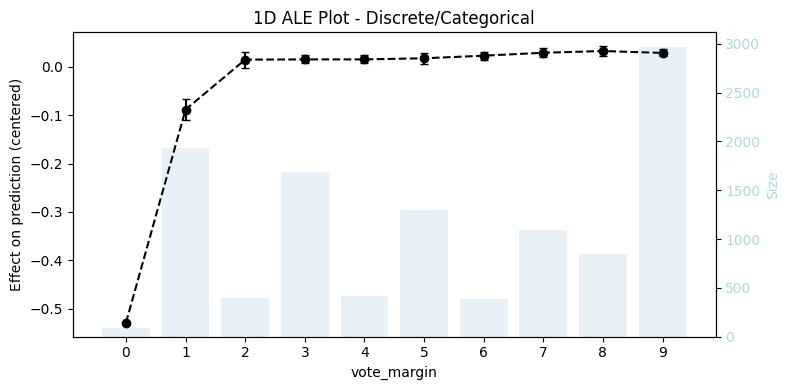

In [24]:
ale(X=X_train, model=model, feature=["vote_margin"])

### What it shows:

x-axis: vote margin (0 = tie, 9 = unanimous).

y-axis: centered effect on petitioner win probability.

Bars (light blue) show how many cases fall in each bin.

Black dots/line = ALE effect with confidence intervals.

### Interpretation:

At margin = 0 (tie), petitioner win probability is very negative → ties usually mean the petitioner loses.

At margin = 1–2, effect still negative but smaller.

At margin ≥ 3, the effect levels out around 0 or slightly positive → meaning once there’s a clear majority, petitioner win probability isn’t systematically higher/lower.

Unanimous (9–0) cases cluster near 0 effect → petitioners aren’t particularly advantaged here.

## Takeaway:
Close cases (especially ties) are bad news for petitioners. Wide margins don’t systematically help either side.